# Self-Implementation : Neural Network-Based Parameter Estimation in Dynamical Systems



In [24]:
# Historical market share data for competitors
# From "Lotka-Volterra Model Parameter Estimation Using Experimential Data"
import pandas as pd

period = []
for year in range(1998, 2008):
    for c in ['a','b']:
        if year == 2007 and c == 'b':
            #print(year, c)
            break
        else:
            period.append(f'{year}'+c)
        
data = {
    'Period': period,
    'x': [0.52, 0.47, 0.43, 0.40, 0.38, 0.37, 0.36, 0.36, 0.35, 0.36, 0.37, 0.38, 0.39, 0.38, 0.37, 0.38, 0.38, 0.36, 0.34],
    'y': [0.15, 0.21, 0.27, 0.31, 0.35, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.40, 0.39, 0.38],
    'z': [0.33, 0.32, 0.30, 0.29, 0.28, 0.27, 0.27, 0.27, 0.27, 0.25, 0.24, 0.23, 0.22, 0.23, 0.24, 0.23, 0.22, 0.25, 0.28]
}

df = pd.DataFrame(data)

df

,Period,x,y,z
0,1998a,0.52,0.15,0.33
1,1998b,0.47,0.21,0.32
2,1999a,0.43,0.27,0.30
3,1999b,0.40,0.31,0.29
4,2000a,0.38,0.35,0.28
5,2000b,0.37,0.36,0.27
6,2001a,0.36,0.37,0.27
7,2001b,0.36,0.37,0.27
8,2002a,0.35,0.38,0.27
9,2002b,0.36,0.38,0.25


In [38]:
import numpy as np

# 2) Normalizer
class DataNormalizer:
    def __init__(self, data: np.ndarray, method: str = 'minmax'):
        if method == 'minmax':
            self.min_ = data.min(axis=0, keepdims=True)
            self.max_ = data.max(axis=0, keepdims=True)
        elif method == 'zscore':
            self.mean_ = data.mean(axis=0, keepdims=True)
            self.std_  = data.std(axis=0, keepdims=True)
        else:
            raise ValueError("method must be 'minmax' or 'zscore'")
        self.method = method
        
    def normalize(self, data: np.ndarray) -> np.ndarray:
        if self.method == 'minmax':
            return (data - self.min_) / (self.max_ - self.min_)
        else:
            return (data - self.mean_) / self.std_
        
    def denormalize(self, data_norm: np.ndarray) -> np.ndarray:
        if self.method == 'minmax':
            return data_norm * (self.max_ - self.min_) + self.min_
        else:
            return data_norm * self.std_ + self.mean_





t_data = np.array([i for i in range(0,19)], dtype=np.float32)
data = df[['x','y','z']].values.astype(np.float32)


t_scaler = DataNormalizer(t_data, method='zscore')
d_scaler = DataNormalizer(data, method='zscore')





In [39]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn

class LVNet(nn.Module):
    def __init__(self, n_layers=1, n_neurons=20, activation='tanh'):
        super(LVNet, self).__init__()
        self.input_layer = nn.Linear(1, n_neurons)

        layers = []
        for _ in range(n_layers):
            layers.append(self._get_act(activation))
            layers.append(nn.Linear(n_neurons, n_neurons))
        self.hidden = nn.Sequential(*layers)
        self.output_layer = nn.Linear(n_neurons, 3)
        self.act = self._get_act(activation)

    def forward(self, t):
        if t.dim() == 1:
            t = t.unsqueeze(1)       # → (batch,1)
        x = self.act(self.input_layer(t))
        x = self.hidden(x)
        out = self.output_layer(x)
        return out

    def _get_act(self, name):
        return {
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'relu': nn.ReLU()
        }[name]


In [42]:
# Parameter Estimation via Optimization
from scipy.optimize import minimize

def estimate_params(t: np.ndarray, y: np.ndarray):
    # t: (N,) or (N,1), y: (N,3)
    N = y.shape[0]
    dydt = np.zeros_like(y)

    # central difference: denominator을 (N-2,1)로 reshape
    dt = (t[2:] - t[:-2])[:, None]    # → shape (N-2,1)
    dydt[1:-1] = (y[2:] - y[:-2]) / dt

    # endpoints: scalar로 나눠도 (3,) → (3,)로 잘 broadcast
    dydt[0]  = (y[1] - y[0]) / (t[1] - t[0])
    dydt[-1] = (y[-1] - y[-2]) / (t[-1] - t[-2])
    
    def loss_fn(params):
        a10,a11,a12,a20,a21,a22,a30,a31,a32 = params
        x_ = y[:,0]; y_ = y[:,1]; z_ = y[:,2]
        dx_pred = a10*x_ + a11*x_*y_ + a12*x_*z_
        dy_pred = a20*y_ + a21*y_*x_ + a22*y_*z_
        dz_pred = a30*z_ + a31*z_*x_ + a32*z_*y_
        res = np.concatenate([(dydt[:,0]-dx_pred),
                              (dydt[:,1]-dy_pred),
                              (dydt[:,2]-dz_pred)])
        return np.sum(res**2)
    
    init = np.zeros(9)
    result = minimize(loss_fn, init, method='BFGS')
    return result.x

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# 5) Walk-forward training + evaluation
min_train = 5
lr = 0.01
n_epochs = 10000
n_layers = 1
n_neurons = 20
activation = 'tanh'
N = len(t_data)
validation_errors = []

params_all = []


for i in range(min_train, N):
    # Prepare train/val data
    t_train, y_train = t_data[:i], data[:i]
    t_train_norm = t_scaler.normalize(t_train)
    y_train_norm = d_scaler.normalize(y_train)
    t_val_norm = t_scaler.normalize(t_data[i:i+1])
    y_val_norm = d_scaler.normalize(data[i:i+1])
    
    # PyTorch datasets
    train_ds = TensorDataset(torch.from_numpy(t_train_norm), torch.from_numpy(y_train_norm))
    train_loader = DataLoader(train_ds, batch_size=len(train_ds), shuffle=False)
    
    # Model, optimizer, loss
    model = LVNet(n_layers=n_layers, n_neurons=n_neurons, activation=activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Train
    model.train()
    for epoch in range(n_epochs):
        for t, y in train_loader:
            optimizer.zero_grad()
            pred = model(t)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
    
    # Estimate parameters on denormalized train predictions
    model.eval()
    with torch.no_grad():
        y_pred_norm = model(torch.from_numpy(t_train_norm)).numpy()
    y_pred_denorm = d_scaler.denormalize(y_pred_norm)
    t_denorm = t_scaler.denormalize(t_train_norm).ravel()
    params = estimate_params(t_denorm, y_pred_denorm)
    params_all.append(params)
    
    # Validation error
    with torch.no_grad():
        val_pred_norm = model(torch.from_numpy(t_val_norm)).numpy()
    val_pred_denorm = d_scaler.denormalize(val_pred_norm)
    y_val_denorm = d_scaler.denormalize(y_val_norm)
    val_error = np.mean((val_pred_denorm - y_val_denorm)**2)
    validation_errors.append(val_error)

# Display results
validation_errors = np.array(validation_errors)
params_all = np.array(params_all)

print("Validation MSE per step:", validation_errors)
print("Estimated parameters per step:", params_all)

Validation MSE per step: [1.3220498e-04 1.5140748e-04 6.6626897e-05 9.3571165e-05 9.8001165e-04
 2.9460280e-04 2.5618050e-04 7.7562225e-05 1.8396943e-04 2.5973989e-06
 2.0656966e-05 1.3480557e-04 6.5169885e-04 1.2531689e-03]
Estimated parameters per step: [[-8.54887891e-02 -5.44346800e-03  5.71200980e-03  1.52113458e-01
   7.17335042e-04 -3.71250661e-03 -3.58832848e-02 -1.36084868e-02
   0.00000000e+00]
 [-6.97131518e-02  2.22024804e-02 -3.21542519e-03  1.15998668e-01
  -5.70264734e-02  2.66725561e-02 -3.44904970e-02 -3.43493053e-03
  -3.43493053e-03]
 [-7.11430666e-02  1.46125247e-01 -1.72816396e-01  7.59774359e-02
  -2.67223512e-02  1.00998106e-01 -2.28162436e-03 -6.52390253e-02
  -5.64212987e-03]
 [-5.56605203e-02  4.66670292e-03 -3.33584468e-02  7.08349993e-02
   3.58304409e-02  2.40655747e-02 -1.30163191e-02  1.64611166e-03
   4.54367625e-03]
 [-6.34179769e-02  1.47107104e-02 -2.75643822e-02  7.81178792e-02
   6.42149789e-03  4.96994193e-08 -6.42148088e-03  4.96994193e-08
   4.969

In [ ]:

# 2) 모델 예측 → 정규화된 출력 획득
model.eval()
with torch.no_grad():
    t_all = torch.from_numpy(t_scaler.normalize(t_data)).float()
    y_pred_n = model(t_all).detach().cpu().numpy()   # (N,3)

# 3) 역정규화
y_pred = d_scaler.denormalize(y_pred_n)             # (N,3) 실제 스케일

# 4) DataFrame 으로 정리해 비교
import pandas as pd

df_compare = pd.DataFrame({
    'Period': df['Period'],
    'x_true': df['x'],
    'y_true': df['y'],
    'z_true': df['z'],
    'x_pred': y_pred[:,0],
    'y_pred': y_pred[:,1],
    'z_pred': y_pred[:,2],
})

print(df_compare)

np.sqrt(np.mean((df_compare['x_true'] - df_compare['x_pred'])**2))

import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.plot(df_compare['Period'],df_compare['x_true'], 'o', label = 'Measured x')
plt.plot(df_compare['Period'],df_compare['x_pred'], label = 'Prediced x')
plt.plot(df_compare['Period'],df_compare['y_true'], 'o', label = 'Measured y')
plt.plot(df_compare['Period'],df_compare['y_pred'], label = 'Prediced y')
plt.plot(df_compare['Period'],df_compare['z_true'], 'o', label = 'Measured z')
plt.plot(df_compare['Period'],df_compare['z_pred'], label = 'Prediced z')
plt.legend()
plt.title('Neural Network Predictions vs. Measured Data')

   Period  x_true  y_true  z_true    x_pred    y_pred    z_pred
0   1998a    0.52    0.15    0.33  0.519646  0.149892  0.330591
1   1998b    0.47    0.21    0.32  0.470624  0.210713  0.317825
2   1999a    0.43    0.27    0.30  0.429826  0.267539  0.303229
3   1999b    0.40    0.31    0.29  0.399626  0.314279  0.289054
4   2000a    0.38    0.35    0.28  0.380166  0.346071  0.278015
5   2000b    0.37    0.36    0.27  0.369250  0.362270  0.271912
6   2001a    0.36    0.37    0.27  0.362228  0.368438  0.270385
7   2001b    0.36    0.37    0.27  0.356196  0.372197  0.270048
8   2002a    0.35    0.38    0.27  0.353613  0.377071  0.265955
9   2002b    0.36    0.38    0.25  0.358104  0.382775  0.255339
10  2003a    0.37    0.39    0.24  0.369638  0.387949  0.239726
11  2003b    0.38    0.39    0.23  0.382372  0.391046  0.225819
12  2004a    0.39    0.39    0.22  0.386904  0.390970  0.222685
13  2004b    0.38    0.39    0.23  0.380456  0.388838  0.231154
14  2005a    0.37    0.39    0.24  0.373

0.00877251257494891

Text(0.5, 1.0, 'Neural Network Predictions vs. Measured Data')

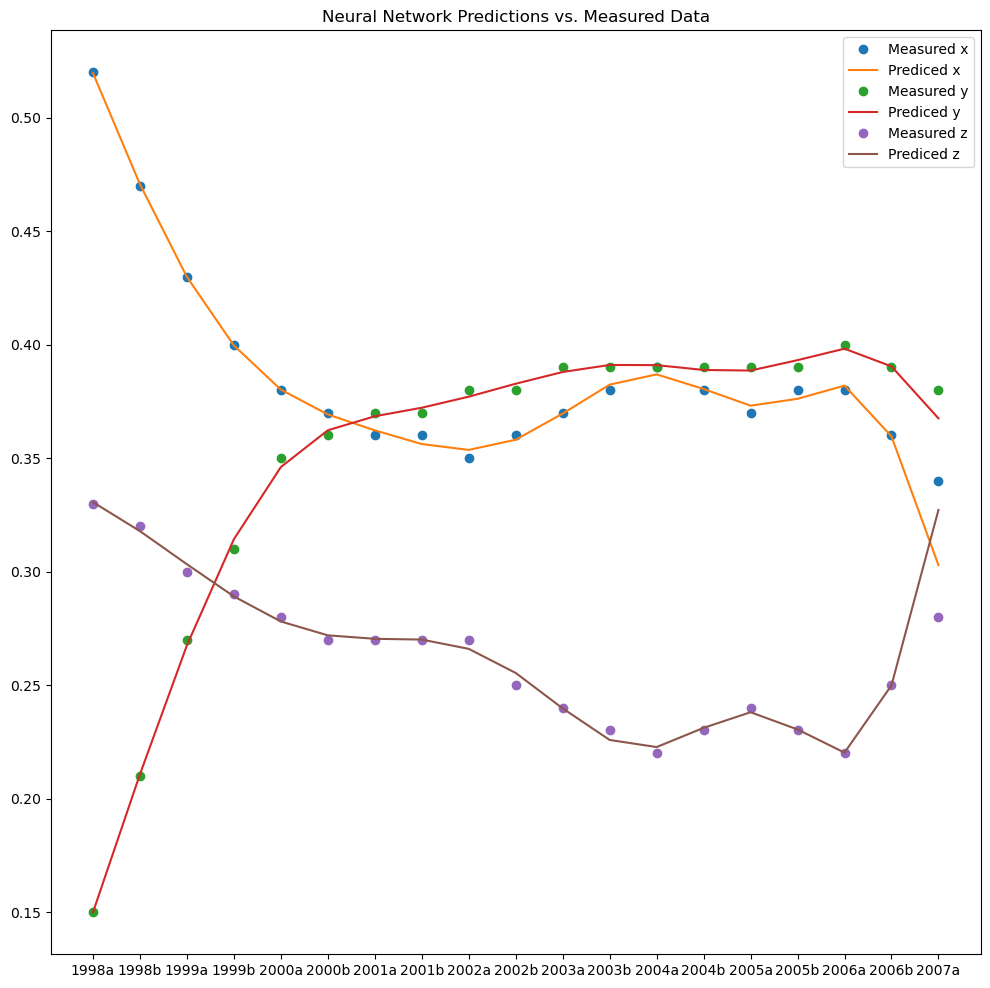

In [44]:
import numpy as np

# y_val_truths, y_val_preds 는 리스트 형태로
# 각 원소가 (3,) shape인 denormalized [x, y, z] 어레이라고 가정
truths = np.vstack(y_val_truths)   # shape (M,3)
preds  = np.vstack(y_val_preds)    # shape (M,3)

# 변수별 제곱오차
se = (preds - truths)**2           # shape (M,3)

# RMSE 계산
rmse = np.sqrt(np.mean(se, axis=0))
rmse_x, rmse_y, rmse_z = rmse

# Mean RMSE
mean_rmse = np.mean(rmse)

print(f"RMSE X: {rmse_x:.4f}")
print(f"RMSE Y: {rmse_y:.4f}")
print(f"RMSE Z: {rmse_z:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")


NameError: name 'y_val_truths' is not defined

In [45]:
import numpy as np
import pandas as pd

# params_all: (M,12) 배열, 순서대로 [a10,a11,a12,a13,a20,…,a33]
param_names = [
    'a10','a11','a12','a13',
    'a20','a21','a22','a23',
    'a30','a31','a32','a33'
]

means = np.mean(params_all, axis=0)
stds  = np.std(params_all,  axis=0)
cvs   = stds / np.abs(means)

stats = pd.DataFrame({
    'mean': means,
    'std': stds,
    'cv': cvs
}, index=param_names)

print(stats)



ValueError: Length of values (9) does not match length of index (12)